# MNIST Handwritten Digit Classifier

## Introduction

This notebook uses a number (presently 2) different approachs to classify handwritten digits (zero through nine) in the MNIST dataset. A detailed description of the dataset and a catolog of previous analysis on the datset can be found here: http://yann.lecun.com/exdb/mnist/. The first approach applies logistic regression as a one-vs-all multi-class classification. This approach is fully developed and acheived around an 10% error rate, which is expected for the simplicity of the logistic regression approach and the fact that I didn't overly optimize the number of iterations and tune the hyperparameters. The second approach utilized a 3-layer neural network with a softmax function as the final activation layer, which is all coded in tensorflow. Using 300 hidden units, the network acheives an error rate of X%, which is comparable to a similar network's error rate tested in 	LeCun et al. 1998.

Acknowledgement: As with many people in the machine learning community, I am indebted to Andrew Ng for his courses on Coursera with Stanford and Deeplearning.ai for teaching me how to develop machine learning algorithms. He is a great teacher.

## Future Work

The future work section is rarely put at the beginning, but this serves as a sort of to-do list of me and also shows that things have been done. 

Ideas for improvement
 - tune alpha (and lambda)
 - add regularization
 - use mini-batches for optimization
 - Use other algorithms like
     - apply neural networks w/ softmax
     - apply SVM's
     - apply kNN
     - apply decision trees
 - Comparisons
     - optimizations: gradient descent vs Adam vs others?
     - initialization: random normal vs Xavier vs others?
 - Perform error analysis on the examples the network is getting incorrect
 
Missteps
 - for the tensorflow model, I forgot to convert the y-labels into a one-hot matrix. 
 
 
 Executed improvements
  - plot the decrease in the cost function
  - normalize the pixel values of the input data
  - try a neural network architecture
  - use a softmax function for multi-class classification
  - implement tensorflow model
  - implement Adam optimization - easily done in tensor flow
  - experiment with diffent initializations like Xavier and random normal - could be illustrated through comparison


In [250]:
import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.python.framework import ops


## The Dataset

The dataset was downloaded from http://yann.lecun.com/exdb/mnist/ and then unzipped. The data was then processed using the mlxtend.data library outlined here:  https://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/

In [4]:
X_train_org, y_train_org = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')

X_test_org, y_test_org = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

The images of each digit are made up for 28 x 28 pixels (784 total), which have been reformatted into a single vector of length 784. There are 60,000 images in the training set and 10,000 in the test set. The y_train and y_test are oddly shaped, which is a concern, though it doesn't effect the analyis in the end. I tried to remedy this using the np.squeeze function, but it didn't work. 

In [5]:
print('X_train dimensions: %s x %s' % (X_train_org.shape[0], X_train_org.shape[1]))
print('y_train dimensions:'+ str(y_train_org.shape )) 
print('X_test dimensionss: %s x %s' % (X_test_org.shape[0], X_test_org.shape[1]))
print('y_test dimensions:'+ str(y_test_org.shape )) 
print('Example of X_train:', X_train_org[0:15,0:15])
print('Example of y_train:', y_train_org[0:15])

X_train dimensions: 60000 x 784
y_train dimensions:(60000,)
X_test dimensionss: 10000 x 784
y_test dimensions:(10000,)
Example of X_train: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Example of y_train: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1]


Below are images of what a given example of the handwritten digits look like. 

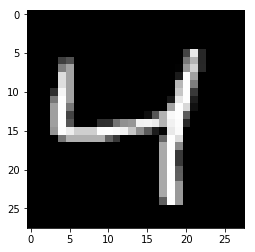

In [6]:
example_number = 2
img = X_train_org[example_number,:].reshape(28,28)
plt.imshow(img, cmap='gray')

The data is currently formatted with the rows being the nummber of examples, (m=60,000), and the columns being the features, (n=784). The analysis I will perform has the data transposed, with size n x m, which will be done below. Additionally, I have scaled the data to be within zero and 1 by dividing by 255, as the pixel values are 8-bit integers. 
I remedied the missing column values in y_train and y_test with by putting them inside a np.array and transposed the y-values as well. 

In [327]:
X_train = X_train_org.T/255
X_test = X_test_org.T/255

y_train = np.array([y_train_org.T])
print(y_train.shape)
y_test = np.array([y_test_org.T])

#training data for only the one-digit which will be used to test the single-digit classifier
y_train_ones = y_train ==1
y_test_ones = y_test ==1

(1, 60000)


# 1) Logistic Regression using one-vs-all classification

The methodology of using binary classification in one-vs-all multiclassification is outlined briefly here: http://mlwiki.org/index.php/One-vs-All_Classification. A binary classifier using logistic regression will be trained separately for each digit. This means that the dataset will be modified where only zero's are a positive result (y=1) and all other digits are a negative result (y=0). The binary classifier will then be trained to identify zero's (y=1) resulting in a weights matrix (generally denoted W, but denoted W0 for the weights of the zero classifier) and the bias vector, b (also denoted b0 for the zero classifier). 

10 classifiers will be trained for each digit each with their own weights (W) and bias (b). Then, each example will be run through the 10 classifiers and the classifier that yields the greatest value, indicating the strongest classification, will be chosen. Through this way, the entire dataset can be used to classified.

In [8]:
def initialize():
    '''
    Description
    This funciton initializes the parameters in the classifier with the W-weights initialized to small random
        numbers and the bias term, b, intialized to zeros.
    
    Input
    For a simple classifier, no inputs are needed because there is only a single W matrix and a single b-vector.
    For a neural network, separate weight matricies and bias vectors need to be created for each layer.
    
    Output
    W - the weight matrix
    b - the bias vector
    
    '''
    
    np.random.seed(2) #sets the seed of the random number generator
    
    W = np.random.randn(1, X_train.shape[0])*0.01
    #the '[0]' term below is used to strip one set of square brackets off b so that its shape is consisent with db below
    b = np.zeros((1,1))
  
    
    #the assert statements are used to ensure the W and b matricies have the correct shape.
    assert(W.shape == (1, X_train.shape[0]))
    assert(b.shape == (1,1))
        
    return W, b
    

In [9]:
#this commmented command can be used to check the output of the initialize fuction
#initialize()

In [10]:
def sigmoid(x):
    '''
    Description
    The sigmoid function, which is used in logistic regression.
    
    Input
    A value or np.array, x
    
    Ouput
    The sigmoid of the input
    '''
    
    sig = 1/(1+np.exp(-x))
    
    return sig

At large negative values, the sigmoid function outputs zero; at zero, the sigmoid outputs 0.5; and at large positive values, the sigmoid outputs one.

In [11]:
sig_test = np.array([-10,0,10])
sigmoid(sig_test)

array([4.53978687e-05, 5.00000000e-01, 9.99954602e-01])

In [12]:
def forward_prop(W, b, X):
    '''
    Description
    This function calculates the forward progagation of logistic regression. Here the activation function is
        the sigmoid function
    
    Input
    W - the weight matrix
    b - the bias bector
    X - the input data
    
    Output
    Z - the linear multiplication of W and X added to the bias term, b
    A - the activation value, which is the activation function computed on the Z-value
    
    '''
    
    Z = np.dot(W, X) + b
    A = sigmoid(Z)    
        
    return A, Z

The propagation function which conducts the forward propagation step, computes the cost function, and updates the W and b terms using gradient descent. Gradient descent is done by calculating the derivative of the cost function with respect to the W and b terms. This derivative is calculated using the chain rule. 

The best concise description I can find for this is here: https://medium.com/technology-nineleaps/logistic-regression-gradient-descent-optimization-part-1-ed320325a67e - through this article doesn't derive the derivative calculations, dW (which is shorthand for $\partial$C/$\partial$W where C is the cost funcition) and db (which is also $\partial$C/$\partial$b).

In [13]:
def propagate(X, W, b, Y):
    '''
    Description:
    Calls the forward_prop function top conduct forward propogation, calculates the cost function, and calculates
        the derivatives of the cost function with respect to W and b to implement gradient descent to update W and b.
    
    Input:
    X   - the training data
    W   - the weights
    

    Output:
    cost    - the cost function calculated
    dW   - the gradient of the W-weight
    db   - the gradient of the bias term, b
    '''
    

    A, Z = forward_prop(W, b, X)
    
    m = A.shape[1]
    
    #calculating the cost function of logistic regressions
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1-A), axis=1) 
    
    #calculates the gradients of W and b
    dW = 2/m * np.dot(A - Y, X.T)
    db = np.array([1/m * np.sum(A - Y, axis=1)])
    #print(db.shape)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)

            
    return cost, dW, db

In [132]:
def single_digit_classifier(X_train, Y_train, learning_rate=0.1, iterations = 1000, print_cost = True):
    '''
    Description
    Runs the logistic regression for a single digit

    Inputs
    X_train - the input features of the training data
    Y_train - the labels of the digits in the training set
    learning_rate - the learning rate used in gradient descent, set to 0.1 by default
    iternations - the number of iterations of the gradient descent, set to 500 by default
    print_cost - a binary label to see if the cost of of every 100 iterations will be printed
    
    Outputs
    W - the final value of the W-weight optimized by gradient descent
    b - the final value of the b bias term optimized by gradient descent
    costs - a list of the costs calculated over the iterations
    
    '''
    
    costs = []
    W, b = initialize()
    
    for i in range(iterations):

        cost, dW, db = propagate(X_train, W, b, Y_train)
        
        W = W - learning_rate * dW
        b = b - learning_rate * db
        
        
        if print_cost and i % 200 == 0:
            print('Cost for ' + str(i) + '= ' + str(cost) ) 
        
        if print_cost and i % 10 == 0:
            costs.append(cost)
            
    if print_cost : 
        plt.plot(costs)
        plt.ylabel('Costs')
        plt.xlabel('Iterations (x10)')
        plt.title("Learning rate is: "+ str(learning_rate))
        plt.show()
    
    return W, b, costs

Cost for 0= [0.6539679]
Cost for 200= [0.04773371]
Cost for 400= [0.04133387]
Cost for 600= [0.03861992]
Cost for 800= [0.03699522]


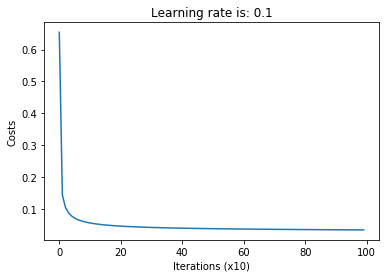

In [134]:
sd  = single_digit_classifier(X_train, y_train_ones)

Based on the long tail of the cost functions exponential decrease, we can safely say that gradient descent has run through a sufficient number of iternations. If without seeing the long tail, we likely could increase the algorithm's performance by running gradient descent for more iterations.

In [39]:
def single_digit_error(X,W,b, y):
    '''
    Description
    Calculates the error of the predictions for the single digit classifier. In this function, the classifier is
        seen to "predict" a certain value if the A-values are greater than 0.5, which is the classification threshold.
        This will not be how the error is calculate or how prediction is calculated with multiple digits. 
    
    Inputs
    The usual suspects
    
    Ouput
    The error term which is the average deviation of the predictions from the y-labels
    '''
    
    A, Z = forward_prop(W,b,X)
    
    predictions = A>0.5*1.0
    
    m = predictions.shape[1]
    
    error = 1/m * np.sum(predictions!=y)
    
    return error

Running the error function for the single digit classifier

In [40]:
single_train_error = single_digit_error(X_train, sd[0], sd[1], y_train_ones)
single_test_error = single_digit_error(X_test, sd[0], sd[1], y_test_ones)
print('Training set error: ', single_train_error)
print('Test set error: ', single_test_error)


Training set error:  0.010833333333333334
Test set error:  0.008


The method of making predictions in the single_digit_error calculator is likely inaccurate as the training set error and test set errors are too small when seen in the context of the performance of other learning algorithms on this dataset, as shown here: http://yann.lecun.com/exdb/mnist/. The lowest error on the dataset was 0.23 from using a 35 layer neural network. Granted, the error calculated above is only for classifying a single digit, while the 0.23 is for classifying all digits. One potential reason why our single digit classifer is doing so well could be do to the low frequency of positive events (y=1). There are around 6,500 ones in the dataset, which is roughly 10% of the dataset, which means that even if no learning occured and the algorithm always predicted a y=0, it would have a 10% error rate. 

I won't spend too much time disecting the reason for the low error rate, as simply classifying ones is only 1/10 of the stated mission. 

## Multi-digit Classifier

In [140]:
def multi_digit_classifier(X_train, y_train, learning_rate):
    '''
    Description
    This function calls the single_digit_classifier fuction on every number in the data set (0-9), which generates
    W and b values for each digit. 
    
    Input
    X_train - the features in the training set
    y_train - the labels of the features in the training set
    learning_rate - the learing rate used in gradient descent - it is an input to the single_digit_classifier
    
    Output
    parameters - a dictionary of the W and b parameters for each digit classifier with labels 'W0' for the 
        W-weight of the zero classifier and 'b0' for the b-term of the zero classifier.
        
    '''
    
    parameters = {}
#    cost_dic = {}
    m = X_train.shape[1]
    
    for i in range(10):
        y_train_temp = y_train ==i
        W, b, costs = single_digit_classifier(X_train, y_train_temp, learning_rate, print_cost=False)
        parameters['W_'+str(i)] = W
        parameters['b_'+str(i)] = b
#        costs['costs_'+str(i)] = costs


    return parameters

Running the multi-digit classifier. The classifier takes almost 3 minutes to run, which doesn't bode well for parameter tuning. In future work, I may consider how to reduce the number of for-loops to try to speed up the computation time.

In [141]:
time1 = time.time()
multi_digit_parameters = multi_digit_classifier(X_train, y_train, learning_rate=0.1)
time2 = time.time()
print('Minutes to run classifier: ', (time2-time1)/60 )

Minutes to run classifier:  6.717435685793559


In [148]:
def multi_digit_predict(parameters, X):
    '''
    Description
    This function uses the parameters of the multi_digit_classifier to calculate the A-values for each single 
        digit classifier and takes the digit with the maximum A-value as the predicted digit.
    
    Input
    parameters - the W and b values for each single digit classifier outputted from the multi_digit_classifier
    X          - the the feature data that will be used along with the parameters to calculate the A-values 
    
    Output
    predictions - a list of the predicted numbers for each of the examples in the dataset, X
    
    '''
    
    A_values, Z = forward_prop(parameters['W_'+str(0)], parameters['b_'+str(0)], X)
    for i in range(1,10):
        A_temp, Z = forward_prop(parameters['W_'+str(i)], parameters['b_'+str(i)], X)
        A_values = np.append(A_values, A_temp, axis=0)
    
    predictions = []
    for j in range(X.shape[1]):
        predictions.append(np.argmax(A_values[:,j]))
    
    assert(len(predictions) == X.shape[1])
    
    return predictions

In [149]:
multi_train_predictions = multi_digit_predict(multi_digit_parameters, X_train)
multi_test_predictions = multi_digit_predict(multi_digit_parameters, X_test)

print('A sample of the predictions: ',multi_train_predictions[0:15])

A sample of the predictions:  [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1]


In [150]:
def multi_digit_error(predictions, y):
    '''
    Description
    This function calculates the error for the multi_digit_classifier my taking the average number of incorrrect
    classifications of the y-labels in the training set.
    
    Inputs
    predictions - the predictions of the digits in each image, the output the multi_digit_predict function
    y - the labels of the training set data
    
    Outputs
    error - the average number of incorrect classifications
    
    '''
    
    m = len(predictions)
    error = 1/m * np.sum(predictions!=y)
    
    return error

In [152]:
multi_train_error = multi_digit_error(multi_train_predictions,y_train)
multi_test_error = multi_digit_error(multi_test_predictions,y_test)
print("Multi-digit training error: "+ str(multi_train_error))
print("Multi-digit test error: "+ str(multi_test_error))

Multi-digit training error: 0.09856666666666668
Multi-digit test error: 0.0921


## Logistic Regression Discussion

The error on the training set is around 9.9% and is comparable to the 9.2% test set error. Both of these errors seem reasonable in the context of the performance of other learning algorithms as shown at: http://yann.lecun.com/exdb/mnist/. The error rate of a linear classifier is 12%. 

By comparing the training and test set errors, we can gain insight into the learning algorithm. If the training set error was small compared to the test set error, then the model would have high variance (overfitting). If the training set error was large compared to what we would expect the model to perform, then the model would have high bias (underfitting). Since the training and test set errors are very close, the model is does not have high variance, and since it is performing fairly well compared to the 12% error of a linear classifier, the model does not suffer from high bias, either. 

Adding regularization is a logical next step to improve the performance; however, since the model doesn't suffer from high variance, adding regularization is unlikely to improve the performance dramatically. Instead, it may be better to increase the model's complexity by turning it into a neural network and then add regularization, which will be be the next step in this exercise. 

Or instead, I may analzye the same problem using SVM's to buff up on their application.

# 2) Neural Network Approach using Softmax in Tensorflow - in progress

The code below will use a 3-layer neural network to analyze the handwritten digit dataset. I plan to rewrite the outline of the code below using Tensorflow to have a 3 layer neural network with two layers using a relu activation function and the final layer using a softmax activation function. Coming soon...

The y-labels need to be converted from being a (1 x # examples) where each value is a number from 0 through 9 to a one-hot matrix of shape (10 x # of examples) where the index of the "hot" row indicates the y-label. 

In [387]:
def convert_to_one_hot(V, D):
    '''
    Description:
    Converts a vector V which is a list of labels and converts it into a one hot matrix of depth D
    
    Input:
    V  -- a vector of labels
    D  -- the depth of the one hot matrix, mainly the number of rows where the index of the "hot" row cooresponds
        to the label in vector V
        
    Output:
    one_hot -- the one hot matrix of label vector V
    
    
    '''
    one_hot = np.eye(D)[V.reshape(-1)].T
    
    return one_hot


In [404]:
#converting the y-lables to one hot matricies
y_train_1hot = convert_to_one_hot(y_train, 10)
y_test_1hot = convert_to_one_hot(y_test, 10)

In [419]:
#defines the size of the neural network
layers_dims = [X_train.shape[0], 200, 90, 10] #the older network architecture
layers_dims

[784, 200, 90, 10]

In [408]:
n_x, n_y = 784, 10 #the input size and label size, respecitively
print('n_x: ', n_x)
print('n_y: ', n_y)

n_x:  784
n_y:  10


In [409]:
def create_placeholders(n_x, n_y):
    '''
    Description:
    This creates the placeholders of the tensorflow session.
    
    Inputs:
    n_x -- a scalar of the image size (784 pixels)
    n_y -- a scalar of the number of classes (10 numbers)
    
    Outputs:
    X -- a tf placeholder for the input data of shape [n_x, None] and data type float32
    Y -- a tf placeholder for the input labels of shape [n_y, None] and data type float32
    '''
    
    X = tf.placeholder(dtype=tf.float32, shape = [n_x, None], name='X')
    Y = tf.placeholder(dtype=tf.float32, shape = [n_y, None], name='Y')
    
    return X, Y

In [410]:
X, Y = create_placeholders(n_x, n_y)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(784, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(10, ?), dtype=float32)


In [411]:
def tf_nn_initialize(layers_dims, init='xavier'):
    '''
    Description: 
    Initializes the parameters in neural network based on the size of layers_dims where each value of layers_dims 
        specifies the number of neurons in each layer
        
    Input:
    layers_dims -- a list that defins the number of layers and the number of hidden units in each layer 
        of shape (1 x number of layers + 1)
    init  -- a keyword arguement that defines the kind of initialization for the variables. 
        The two options are 'xavier' for xavier initialization and 'randn' for random normal.
        
    Ouptut:
    parameters -- a dictionary of the intialize parameters for the nueral network
    
    **Note: try comparing random normal and Xavier distribution for initialization
    '''
    
    ld = layers_dims # an abbreviation for layers_dims
    parameters = {}
    
    if init == 'xavier':
        for l in range(1, len(layers_dims)):
            parameters['W'+str(l)] = tf.get_variable('W'+str(l), [ld[l], ld[l-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            parameters['b'+str(l)] = tf.get_variable('b'+str(l), [ld[l], 1], initializer = tf.zeros_initializer())
    
    elif init == 'randn':
        for l in range(1, len(layers_dims)):
            parameters['W'+str(l)] = tf.get_variable('W'+str(l), [ld[l], ld[l-1]], initializer = tf.initializers.random_normal(seed = 1))*0.01
            parameters['b'+str(l)] = tf.get_variable('b'+str(l), [ld[l], 1], initializer = tf.zeros_initializer())
    
    else:
        raise ValueError("Initialization keyword not recognized")

    return parameters


In [412]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = tf_nn_initialize(layers_dims, init='randn')
    for l in range(1,len(layers_dims)):
        print(parameters['W'+str(l)])
        print(parameters['b'+str(l)])

Tensor("mul:0", shape=(25, 784), dtype=float32)
<tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
Tensor("mul_1:0", shape=(20, 25), dtype=float32)
<tf.Variable 'b2:0' shape=(20, 1) dtype=float32_ref>
Tensor("mul_2:0", shape=(10, 20), dtype=float32)
<tf.Variable 'b3:0' shape=(10, 1) dtype=float32_ref>


In [413]:
def tf_nn_forward_prop(X, parameters):
    '''“
    Description:
    Performs the forward propagation steps of the neural network using the relu activiation function
    
    Inputs:
    X -- the input data, of shape (784 x # examples)
    parameters -- a dictionary of the parameters of the neural network, mainly W matricies and b vectors 
        where the weights and bias terms of the first layer have the keys 'W1' and 'b1', respectively.““
    
    Outputs:
    Z_L -- the linear combination of the final layer, which will be fed into the tensorflow cost function,
        of shape (# classes (10) x # examples)
    
    '''
    
    
    cache = {'A0':X} #dictionary of the hidden linear and activation layers where the first A0 is X, the input data
    L = len(parameters)//2 # the number of layers in the neural network
    
    for l in range(1, L): #the loop stops at the L-1 layer because the final activiation layer
        W_l = parameters['W'+str(l)]
        b_l = parameters['b'+str(l)] #unpacking the W and b terms to make the linear combination more readable
        A_prev = cache['A'+str(l-1)] #the previous activation layer value. For l=1, A_prev = A0 = X
        cache['Z'+str(l)] = tf.add( tf.matmul(W_l, A_prev), b_l )
        cache['A'+str(l)] = tf.nn.relu(cache['Z'+str(l)])
    
    cache['Z'+str(L)] = tf.add( tf.matmul(parameters['W'+str(L)], cache['A'+str(L-1)]), parameters['b'+str(L)] )
    Z_L = cache['Z'+str(L)]
    
    return Z_L, cache

In [414]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = tf_nn_initialize(layers_dims)
    Z_L, cache = tf_nn_forward_prop(X, parameters)
    print("Z_L = " + str(Z_L))

Z_L = Tensor("Add_2:0", shape=(10, ?), dtype=float32)


In [415]:
def tf_compute_cost(Z_L, Y):
    '''
    Description:
    Creates a tensor of softmax cost function
    
    Inputs:
    Z_L  --  the linear unit of the last layer in the neural network, of shape (# classes (10) x # examples)
    Y    --  the input labels, of shape (10, # examples)
    
    Outputs:
    cost -- the tensor of the cost function
    '''
    
    #transposes the inputs to fit the needed dimensions of the softmax cost function
    logits = tf.transpose(Z_L)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels) )
    
    return cost

In [416]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = tf_nn_initialize(layers_dims)
    Z_L, cache = tf_nn_forward_prop(X, parameters)
    cost = tf_compute_cost(Z_L, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [420]:
def tf_model(layers_dims, X_train, Y_train, X_test, Y_test, learning_rate = 0.005, iterations=500, print_cost=True):
    '''
    Description:
    The neural network optimization model
    
    Inputs:
    iternations -- a scalar, nummber of iterations of the optimization algorithm
    print_cost  -- a boolean, if True the algorithm will print the cost over a certain number of iterations
    
    
    Outputs:
    parameters -- a dictionary of the trained parameters from the neural network
    
    
    Note: test performance using Adam optimization versus gradient descent
    Note1: Incorporate mini-batches into optimization
    '''
    
    #the code below was taken more directly from the Deeplearning.ai course Improving Neural Networks
    #as I am still learning the ropes of tensorflow
    
    ops.reset_default_graph()           # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)               # to keep consistent results
    seed = 3                            # to keep consistent results
    (n_x, m) = X_train.shape            # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]              # n_y : output size
    costs = []                          # To keep track of the cost
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters = nn_initialize(layers_dims)
    
    Z_L, _ = nn_forward_prop(X, parameters)
    
    cost = compute_cost(Z_L, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:

        sess.run(init)
        
        for i in range(iterations):
            
            _ , iter_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})

            if print_cost == True and i % 100 == 0:
                print ("Cost after iteration %i: %f" % (i, iter_cost))
            if print_cost == True and i % 10 == 0:
                costs.append(iter_cost)
                
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        
        correct_prediction = tf.equal(tf.argmax(Z_L), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        print('Train Accuracy: ', accuracy.eval({X:X_train, Y:Y_train} ) )
        print('Test Accuracy: ', accuracy.eval({X:X_test, Y:Y_test} ) )
        
    return parameters

Cost after iteration 0: 2.327531
Cost after iteration 100: 0.040374
Cost after iteration 200: 0.005340
Cost after iteration 300: 0.001305
Cost after iteration 400: 0.000583


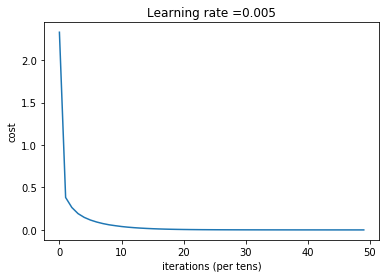

Train Accuracy:  1.0
Test Accuracy:  0.9771


In [421]:
parameters = tf_model(layers_dims, X_train, y_train_1hot, X_test, y_test_1hot)

## Neural network discussion

As can be seen above, the 3-layer neural network softmax classifier performs better than the logistic regression classifier, acheiving 96% on the test set compared with 91% of logistic regression.

The power of the tensorflow framework can be seen as there is no need to specify a back propagation function. The tensor flow objects create are arranged in a computational graph, whose structure allows tensorflow to perform backpropagation automatically. Additionally, using more advanced optimization and initialization algorithms like Adam optimaization and Xavier initialization are a simple as changing a few words in a line of code. I am still learning how to fully understand how the various objects fit together, but it seems a very powerful tool.

The number of hidden units has been varied from 60 to 300. A 300 hidden unit neural network can be compared with the 3-layer 300 hidden unit (plus some additional complexity that I haven't delved into) models described here - http://yann.lecun.com/exdb/mnist/. The 3-layer 300 hidden unit network listed on the website had an error rate of 3%. This compares with the 2.3% error rate of the network above. 

## 3) Old Neural Network Outline without Tensorflow

In [97]:
def relu(x):
    '''
    Description:
    A relu function
    
    Input:
    x -- a numpy array
    
    Output:
    the relu function
    '''
    
    return np.maximum(x,0)

In [103]:
def softmax(X):
    '''
    Description:
    The softmax function
    
    Input:
    
    
    Output:
    
    '''
    
    exps = np.exp(X)
    
    return np.exp(X)/np.sum(exps)
    

In [98]:
def nn_initialize_old(layers_dims):
    '''
    Description: 
    This function initializes all of the parameters for the neural network using the number of layers and hidden
        units definted in layers_dims
    
    Inputs:
    layers_dims -- a vector of the number of hidden units in each layers where the first (zero-th) value is the 
        number of features, m, in the input values
        
    Outputs:
    parameters -- a dictionary of initialized parameters for the neural network
    
    '''

    np.random.seed(2) #sets the seed of the random number generator
    parameters = {}
    
    #as a note - the W parameters are initialized as a product of a random number and root (2/previous layer size)
    # the square root term provides a better initialization of the parameters
    for l in range(1, len(layers_dims)):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b'+str(l)] = np.zeros( (layers_dims[l], 1) )
        
        assert(parameters['W' + str(l)].shape == layers_dims[l], layers_dims[l-1])
        assert(parameters['b'+str(l)]).shape == layers_dims[l],1 )
        
    assert( len(parameters) == 2*( len(layers_dims)-1 ) )
        
    return parameters

In [99]:
param = nn_initialize(layers_dims)
param['W1'].shape

(20, 784)

What is the cost function for a neural network classifying 9 digits? What is the final step of the neural network? 

In [100]:
def nn_forward_prop(parameters, X):
    '''
    Description:
    The forward propagation step in the neural network. For an N-layer neural network, there will be N relu layers
    
    Input:
    parameters -- a dictionary of parameters of the neural network with W1 indicating the W-weight for the first
        layer of the neural network
    X         -- the inputs to the neural network with shape (input size (m) x number of examples (n) )
    
    
    Output:
    A_L       -- the activation value of the final layer of the L-layer neural network
    cache     -- a dictionary of the intermediate Z and A values
    
    '''
    
    L = len(parameters) // 2 # the number of layers in the neural network
    cache = {'A0': X_train}
    
    
    for l in range(1, L+1):
        Z = np.dot(parameters['W'+str(l)],cache['A'+str(l-1)] ) + parameters['b'+str(l)]
        A = relu(Z)
        cache['Z'+str(l)], cache['A'+str(l)] = Z, A
        
    A_L = A
    
#    assert (len(cache)+1 == len(parameters)//2 )
    
    return A_L, cache
                              

In [102]:
A_L, cache = nn_forward_prop(param, X_train)
cache['A2']

array([[0.        , 0.        , 0.00057345, ..., 0.        , 0.        ,
        0.        ],
       [0.00150871, 0.00224729, 0.0021462 , ..., 0.00188633, 0.00103728,
        0.00075334],
       [0.00108241, 0.00308841, 0.00204568, ..., 0.        , 0.00222153,
        0.00308861],
       ...,
       [0.00056204, 0.        , 0.        , ..., 0.00084801, 0.        ,
        0.00449367],
       [0.00577001, 0.00131677, 0.00381508, ..., 0.00138423, 0.00266134,
        0.00168717],
       [0.00240789, 0.00269189, 0.        , ..., 0.00173917, 0.00157735,
        0.00152875]])

In [ ]:
def nn_backward_prop(parameters,X, cache):
    '''
    Description:
    The backward propagation step of the neural network.
    
    Inputs:
    
    
    Outputs:
    
    
    '''
    
    
    
    
    

In [ ]:
def crossEntropy_loss(X, y):
    
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    m = y.shape[0]
    p = softmax(X)
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    log_likelihood = -np.log(p[range(m),y])
    loss = np.sum(log_likelihood) / m
    return loss

In [ ]:
def nn_predict(A_L):
    '''
    Description:
    Takes in the final layer of the neural network and takes the highest value in that layer of the prediction
    
    
    '''

# Scratch work - Tensorflow tutorial

In [105]:
import tensorflow as tf

In [131]:
coefficients = np.array([[1.], [-20.], [10.]])

w = tf.Variable(0, dtype = tf.float32)
x = tf.placeholder(tf.float32, [3,1])
#cost = tf.add( tf.add(w**2, tf.multiply(-10.,w) ), 25)
#cost = w**2 - 10*w + 25
cost = x[0][0]*w**2 + x[1][0]*w + x[2][0]
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

init = tf.global_variables_initializer()
#session = tf.Session()
#session.run(init)
#print(session.run(w))

with tf.Session() as session:
    session.run(init)
    print(session.run(w))

0.0


In [129]:
session.run(train, feed_dict = {x:coefficients})
print(session.run(w))

0.19999999


In [130]:
for i in range(1000):
    session.run(train, feed_dict={x:coefficients})
print(session.run(w))

9.999977
